In [53]:
import copy
import numpy as np
import sys
import json

custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
sys.path.append(custom_module_path)

import instruments as inst

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [54]:
file_path = "/home/rebeccaz/Github/vampires_calibration/data/20230914_processed_table.csv"
wavelength_string = 670
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[  4891.    12895.5   -8596.    13342.5    1190.5   12976.    -5411.5
  13045.    -6623.5   13368.5    2486.    12814.   -12740.5   13944.
   9496.5   12967.5  -13235.    13903.    11358.    13094.5   -8040.5
  13293.     7342.5   13117.5    -674.    12906.      334.5   13393.
   3112.    12875.5   -3963.    13650.     4450.    13125.5   -6885.5
  13580.     6726.5   12994.5   -9906.    13737.5    2201.    13172.5
  -6372.5   13278.    -6036.    13547.5    1799.5   12976.5  -12123.5
  14053.     8802.    12981.   -12333.5   13903.    10326.    13109.5
  -7081.    13226.     6317.    13089.     -227.    12805.      -70.5
  13321.5    1057.    13329.    -2102.5   13579.     8027.5   13096.5
  -9776.    13947.5    9101.    13241.   -12201.    13999.     3880.5
  13327.5   -8014.5   13505.5   -4793.5   13695.5     477.5   13135.5
 -10556.    14132.     7209.5   12967.   -10266.    13911.     8276.
  12972.    -4663.    13153.     3708.25  13091.    -2852.   

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [55]:
import numpy as np

em_gain = 1.18

system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {
                "phi": 0.01136 * 2 * np.pi,
                "epsilon": 0.25090,
                "theta": 44.39655
            }
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {
                "phi": 0.49963 * 2 * np.pi,
                "delta_theta": 0.34584
            }
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {
                "phi": 0.86935 * 2 * np.pi,
                "epsilon": 0.00171,
                "theta": -83.45735
            }
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {
                "phi": 0.31797 * 2 * np.pi
            }
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {
                "phi": 0.45965 * 2 * np.pi,
                "delta_theta": -1.19733
            }
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {
                "theta": 0.36644
            }
        }
    }
}


In [56]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.56781814 0.56777169 0.00726286 0.        ]
 [0.56781814 0.56777169 0.00726286 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Plotting Check

logl value: 10.982480746415927


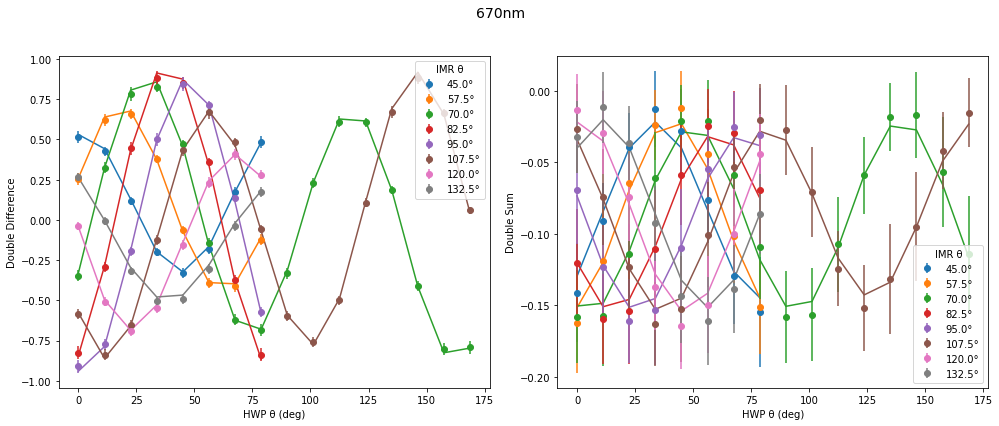

In [59]:
# Fittin for all parameters

p0 = {
    "wollaston": {"transmission_ratio": 1.18}, 
    # "flc": {"phi": 2 * np.pi * delta_FLC, "delta_theta": rot_FLC},
    # "optics": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    # "image_rotator": {"phi": 2 * np.pi * delta_derot, "delta_theta": offset_derot},
    # "hwp": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP},
    # "lp": {"theta": 0}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)